In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
dataset = load_dataset("shreyaspullehf/emotion_dataset_100k")

print("Available splits:", dataset.keys())
print("Columns:", dataset["train"].column_names)

text_column = "sentence"
label_column = "emotion"
print("Text column:", text_column)
print("Label column:", label_column)


print("Detected text column:", text_column)
print("Detected label column:", label_column)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/711 [00:00<?, ?B/s]

emotion_dataset_100k.csv:   0%|          | 0.00/19.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/99746 [00:00<?, ? examples/s]

Available splits: dict_keys(['train'])
Columns: ['sentence', 'emotion']
Text column: sentence
Label column: emotion
Detected text column: sentence
Detected label column: emotion


In [3]:
all_labels = dataset["train"][label_column]
unique_labels = sorted(list(set(all_labels)))

label_to_id = {l: i for i, l in enumerate(unique_labels)}
id_to_label = {i: l for l, i in label_to_id.items()}
num_classes = len(unique_labels)

print("Number of classes:", num_classes)

def encode_labels(example):
    example["label"] = label_to_id[example[label_column]]
    return example

dataset = dataset.map(encode_labels)


Number of classes: 10


Map:   0%|          | 0/99746 [00:00<?, ? examples/s]

Exploratory Data Analysis (EDA)

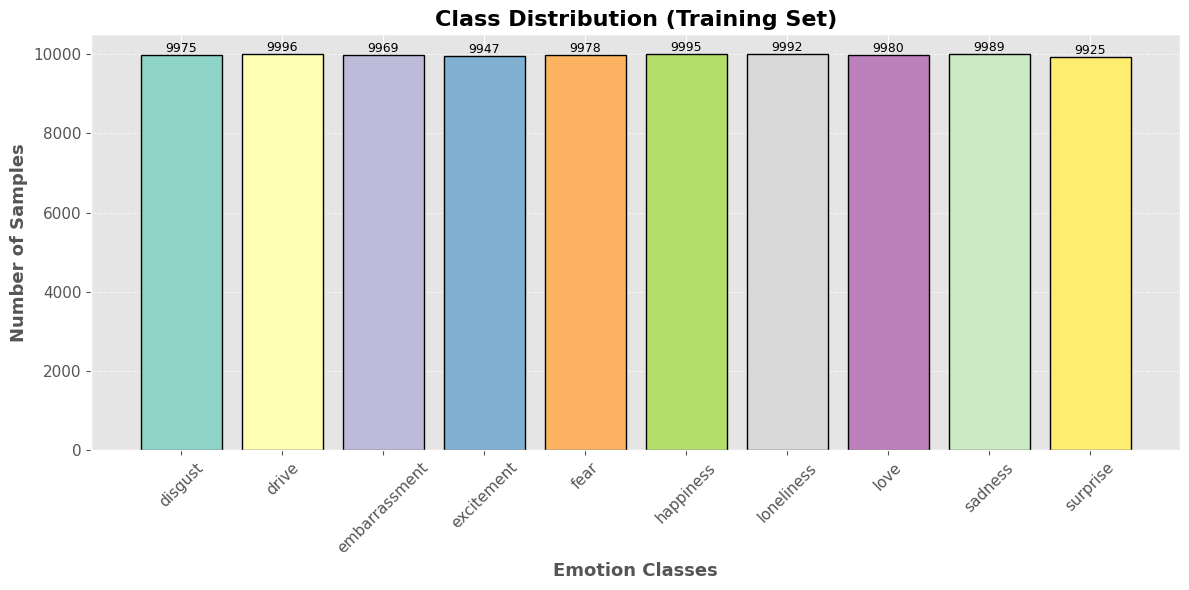

Imbalance ratio: 1.01
→ Dataset is relatively balanced.


In [5]:
plt.style.use("ggplot")

train_labels = [label_to_id[x] for x in dataset["train"][label_column]]
unique, counts = np.unique(train_labels, return_counts=True)

labels = [id_to_label[i] for i in unique]

plt.figure(figsize=(12,6))

colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))

bars = plt.bar(labels, counts, color=colors, edgecolor="black", linewidth=1)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel("Emotion Classes", fontsize=13, fontweight="bold")
plt.ylabel("Number of Samples", fontsize=13, fontweight="bold")
plt.title("Class Distribution (Training Set)", fontsize=16, fontweight="bold")

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

imbalance_ratio = max(counts) / min(counts)
print("Imbalance ratio:", round(imbalance_ratio, 2))

if imbalance_ratio > 2:
    print("→ Dataset shows noticeable class imbalance.")
else:
    print("→ Dataset is relatively balanced.")


The dataset is relatively balanced because the class frequencies are similar.
Therefore, no special techniques such as class weighting or resampling are required.


In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(
        batch[text_column],
        padding="max_length",
        truncation=True,
        max_length=128
    )

dataset = dataset.map(tokenize, batched=True)

dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

from torch.utils.data import random_split

total_size = len(dataset["train"])
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset["train"], [train_size, val_size, test_size]
)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Train batches:", len(train_loader))
print("Validation batches:", len(val_loader))
print("Test batches:", len(test_loader))


print("Train batches:", len(train_loader))
print("Validation batches:", len(val_loader))
print("Test batches:", len(test_loader))

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/99746 [00:00<?, ? examples/s]

Train batches: 4988
Validation batches: 624
Test batches: 624
Train batches: 4988
Validation batches: 624
Test batches: 624


In [7]:
class EmotionClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        cls = outputs.last_hidden_state[:, 0]
        return self.fc(self.dropout(cls))

model = EmotionClassifier(num_classes).to(device)

print("Model parameters:",
      sum(p.numel() for p in model.parameters()))



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model parameters: 109489930


In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()
num_epochs = 2

def train_epoch(loader):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in tqdm(loader):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        logits = model(input_ids, mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item()

    return total_loss/len(loader), correct/total

def evaluate(loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids, mask)
            loss = criterion(logits, labels)

            preds = torch.argmax(logits, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

    return total_loss/len(loader), correct/total

best_val_loss = float("inf")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_epoch(train_loader)
    val_loss, val_acc = evaluate(val_loader)

    print("Train Loss:", train_loss, "Train Acc:", train_acc)
    print("Val Loss:", val_loss, "Val Acc:", val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")


Epoch 1/2


100%|██████████| 4988/4988 [31:51<00:00,  2.61it/s]


Train Loss: 0.2253042225277465 Train Acc: 0.9282294851872275
Val Loss: 0.12648752206923047 Val Acc: 0.9588931221175055

Epoch 2/2


100%|██████████| 4988/4988 [31:58<00:00,  2.60it/s]


Train Loss: 0.08896586533448955 Train Acc: 0.9713895433355055
Val Loss: 0.1326146963373713 Val Acc: 0.9582915580509325


100%|██████████| 624/624 [01:28<00:00,  7.04it/s]


Accuracy: 0.9556936647955092
Precision: 0.9559638579595391
Recall: 0.9556936647955092
F1: 0.9557673708628066

Classification Report:

               precision    recall  f1-score   support

      disgust       0.99      0.99      0.99       937
        drive       0.94      0.96      0.95      1019
embarrassment       0.99      0.98      0.98      1078
   excitement       0.96      0.93      0.95      1015
         fear       0.97      0.97      0.97      1019
    happiness       0.97      0.95      0.96       958
   loneliness       0.94      0.94      0.94      1014
         love       0.98      0.98      0.98      1000
      sadness       0.90      0.92      0.91       961
     surprise       0.92      0.93      0.93       975

     accuracy                           0.96      9976
    macro avg       0.96      0.96      0.96      9976
 weighted avg       0.96      0.96      0.96      9976



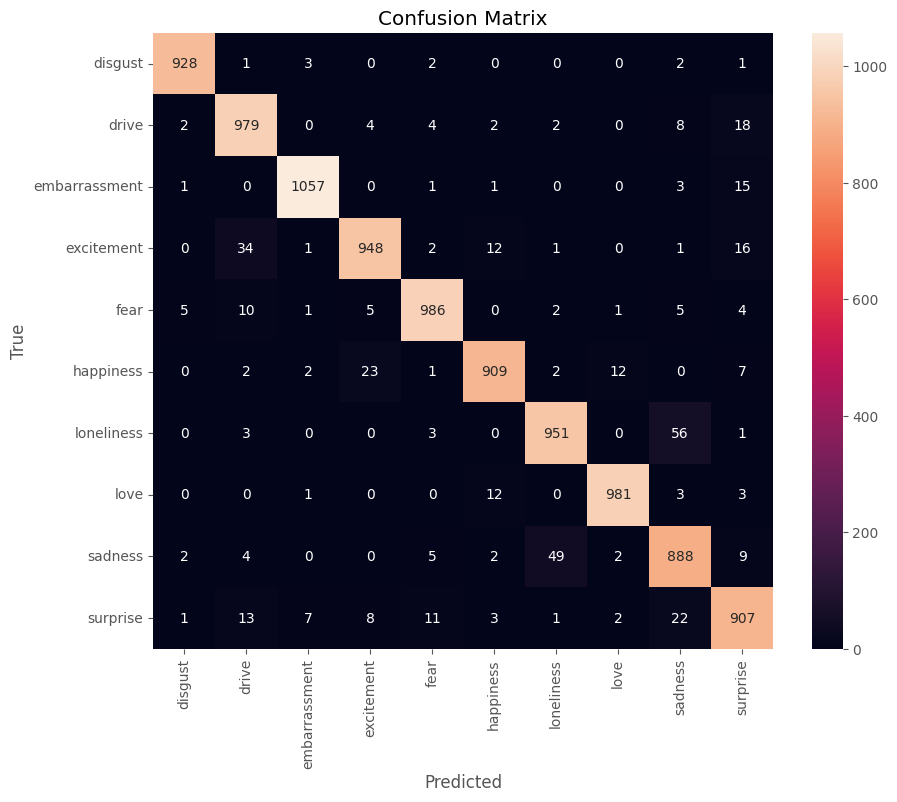

In [12]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        logits = model(input_ids, mask)
        preds = torch.argmax(logits, 1)


        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")
f1 = f1_score(all_labels, all_preds, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds,
                            target_names=[id_to_label[i] for i in range(num_classes)]))

# ---- confusion matrix ----
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=[id_to_label[i] for i in range(num_classes)],
            yticklabels=[id_to_label[i] for i in range(num_classes)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Inference Pipeline

In [10]:
def predict_text(text: str):
    model.eval()

    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        logits = model(**inputs)
        probs = torch.softmax(logits, dim=1)
        pred = torch.argmax(probs, 1)

    return id_to_label[pred.item()], probs.max().item()

In [11]:
examples = [
    "I am extremely happy today!",
    "This situation scares me.",
    "I feel very lonely and sad.",
    "Wow that was surprising!",
    "I love this so much."
]

for text in examples:
    label, conf = predict_text(text)
    print(f"\nText: {text}")
    print("Prediction:", label, "| Confidence:", round(conf, 3))


Text: I am extremely happy today!
Prediction: happiness | Confidence: 0.996

Text: This situation scares me.
Prediction: fear | Confidence: 0.998

Text: I feel very lonely and sad.
Prediction: sadness | Confidence: 0.994

Text: Wow that was surprising!
Prediction: surprise | Confidence: 0.996

Text: I love this so much.
Prediction: love | Confidence: 0.838
